<a href="https://colab.research.google.com/github/Joearrowsmith/Algothon_2019_Workshops/blob/master/Introduction_to_Financial_Machine_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<img src="http://2019.algothon.org/img/icon.png" width="200">

## [Algothon.org](http://algothon.org/)

# Algothon 2019 - Introduction to Financial Machine Learning

## Topics that will be covered in this workshop:

### Intro to Quant Finance:

- What is a financial time series?
- Random walk / Non-Random walk?
- What is a momentum strategy?
- Key Metrics
- Normalisation 
- Managing Risk

### Intro to ML:

- How do we optimise?
- What types of models are there?
- How do we split our data?


---



In [1]:
!pip install quandl

In [0]:
import quandl
quandl.ApiConfig.api_key = "51zhMtVAyF2VgGsWqxzD" # keep this private

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

figsize = (12,4)

# What is a financial time series?



## Close Price for ![BlackRock](http://2019.algothon.org/img/blackrock-logo-sitemap.svg)

In [62]:
start = '2015-10-11'
end = '2019-10-11'

data = quandl.get('EOD/BLK', start_date=start, end_date=end)
close = data['Close']
close.head()

Date
2015-10-12    315.66
2015-10-13    315.12
2015-10-14    322.47
2015-10-15    325.63
2015-10-16    330.83
Name: Close, dtype: float64

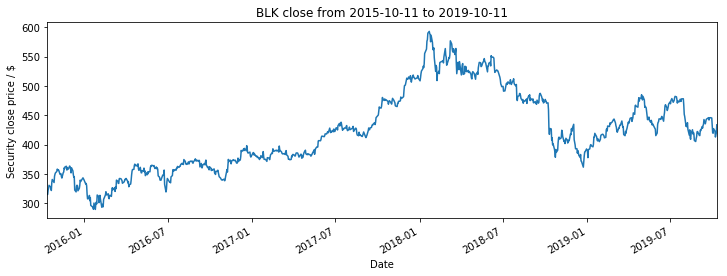

In [63]:
plt.figure(figsize=figsize)
plt.title(f'BLK close from {start} to {end}')
plt.ylabel('Security close price / $')
close.plot(label='Raw')

## Log Returns

In [64]:
log_rets = np.log(close) - np.log(close.shift(1))
log_rets.head()

Date
2015-10-12         NaN
2015-10-13   -0.001712
2015-10-14    0.023057
2015-10-15    0.009752
2015-10-16    0.015843
Name: Close, dtype: float64

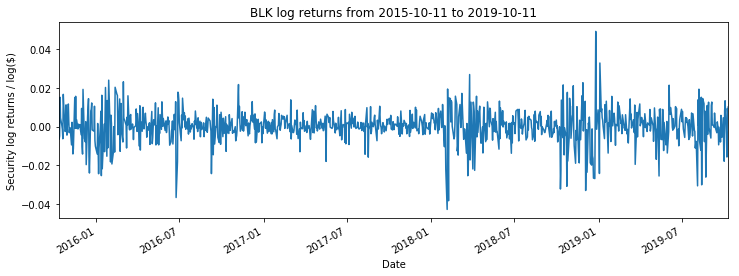

In [7]:
plt.figure(figsize=figsize)
plt.title(f'BLK log returns from {start} to {end}')
plt.ylabel('Security log returns / log($)')
log_rets.plot(label='log rets')

## Volatility

In [8]:
volatility = log_rets.shift(1).ewm(span=252).std()
volatility.head()

Date
2015-10-12         NaN
2015-10-13         NaN
2015-10-14         NaN
2015-10-15    0.001072
2015-10-16    0.012056
Name: Close, dtype: float64

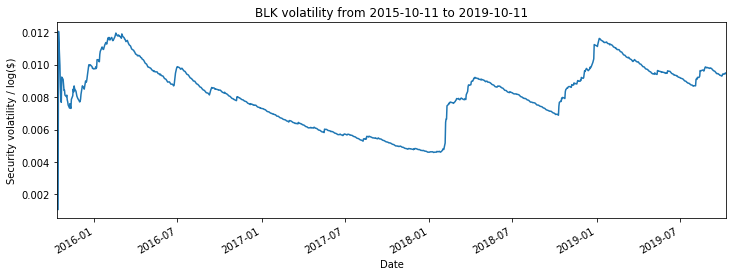

In [9]:
plt.figure(figsize=figsize)
plt.title(f'BLK volatility from {start} to {end}')
plt.ylabel('Security volatility / log($)')
volatility.plot(label='vol')

## Volatility Scaled Returns


https://youtu.be/ZJXsoZprTn8

In [10]:
rets = log_rets / volatility
rets.head()

Date
2015-10-12          NaN
2015-10-13          NaN
2015-10-14          NaN
2015-10-15    14.210150
2015-10-16     0.376276
Name: Close, dtype: float64

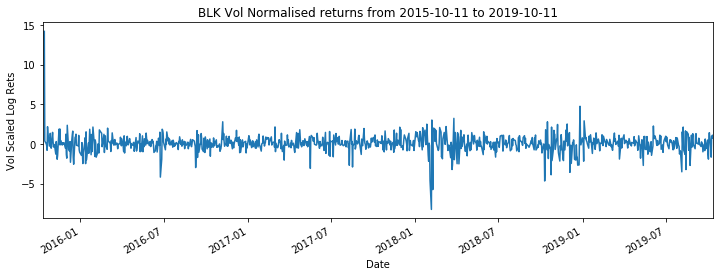

In [11]:
plt.figure(figsize=figsize)
plt.title(f'BLK Vol Normalised returns from {start} to {end}')
plt.ylabel('Vol Scaled Log Rets')
rets.plot(label='vol scaled rets')

# What is a momentum Strategy?

## Signal


In [0]:
slow_period = 300
fast_period = 150

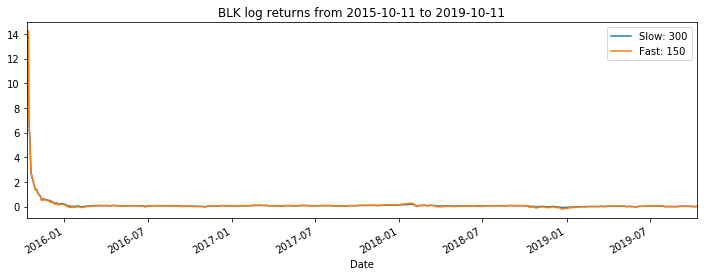

In [13]:
slow_rets = rets.ewm(span=slow_period).mean()
fast_rets = rets.ewm(span=fast_period).mean()

plt.figure(figsize=figsize)
plt.title(f'BLK log returns from {start} to {end}')
slow_rets.plot(label=f'Slow: {slow_period}')
fast_rets.plot(label=f'Fast: {fast_period}')

plt.legend()

In [14]:
diff = fast_rets - slow_rets
diff.head()

Date
2015-10-12         NaN
2015-10-13         NaN
2015-10-14         NaN
2015-10-15    0.000000
2015-10-16   -0.023056
Name: Close, dtype: float64

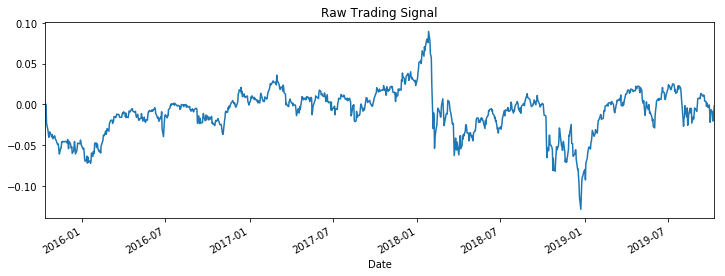

In [15]:
plt.figure(figsize=figsize)
plt.title('Raw Trading Signal')
diff.plot(label='raw signal')

In [0]:
raw_macd = diff

In [0]:
exp_diff = np.sqrt(np.square(diff).ewm(span=60).mean())
rms_macd = diff / exp_diff

In [0]:
std_diff = diff.ewm(span=63).std()
std_macd = diff / std_diff

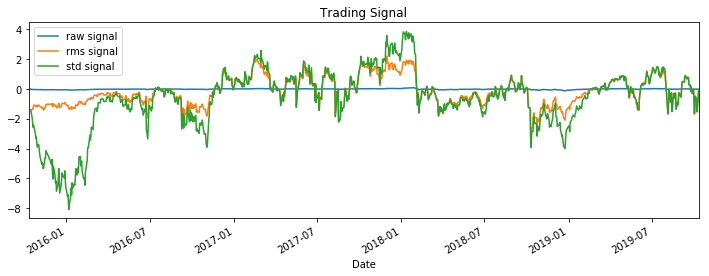

In [51]:
plt.figure(figsize=figsize)
plt.title('Trading Signal')
raw_macd.plot(label='raw signal')
rms_macd.plot(label='rms signal')
std_macd.plot(label='std signal')
plt.legend()

## Position Functions

In [0]:
def moskowitz_pos_func(x):
  # Moskowitz et al. 2012
  return x * np.exp( - (x**2)/4) /0.89

def tanh_pos_func(x):
  return np.tanh(x)

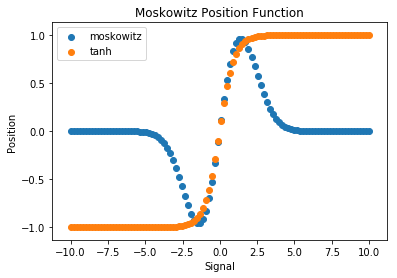

In [20]:
x = np.linspace(-10, 10, 100)
y_moskowitz = moskowitz_pos_func(x)
y_tanh = tanh_pos_func(x)

plt.title("Moskowitz Position Function")
plt.ylabel("Position")
plt.xlabel("Signal")
plt.scatter(x,y_moskowitz, label='moskowitz')
plt.scatter(x,y_tanh, label='tanh')
plt.legend()

In [0]:
moskowitz_raw_pos = moskowitz_pos_func(raw_macd)
moskowitz_rms_pos = moskowitz_pos_func(rms_macd)
moskowitz_std_pos = moskowitz_pos_func(std_macd)

tanh_raw_pos = tanh_pos_func(raw_macd)
tanh_rms_pos = tanh_pos_func(rms_macd)
tanh_std_pos = tanh_pos_func(std_macd)

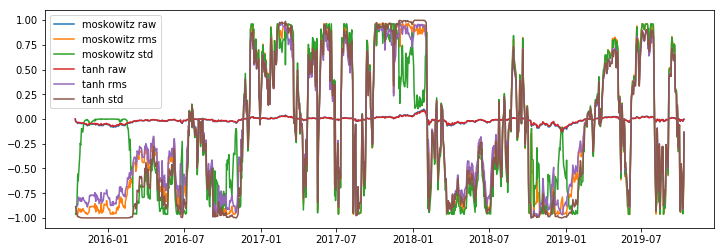

In [53]:
plt.figure(figsize=figsize)
plt.plot(moskowitz_raw_pos, label='moskowitz raw')
plt.plot(moskowitz_rms_pos, label='moskowitz rms')
plt.plot(moskowitz_std_pos, label='moskowitz std')
plt.plot(tanh_raw_pos, label='tanh raw')
plt.plot(tanh_rms_pos, label='tanh rms')
plt.plot(tanh_std_pos, label='tanh std')

plt.legend()

## Performance

In [0]:
target_rets = rets.shift(1)

moskowitz_raw_perf = target_rets * moskowitz_raw_pos
moskowitz_rms_perf = target_rets * moskowitz_rms_pos
moskowitz_std_perf = target_rets * moskowitz_std_pos
tanh_raw_perf = target_rets * tanh_raw_pos
tanh_rms_perf = target_rets * tanh_rms_pos
tanh_std_perf = target_rets * tanh_std_pos

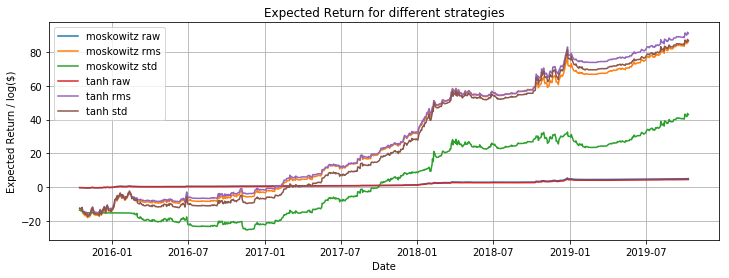

In [60]:
plt.figure(figsize=figsize)
plt.plot(np.cumsum(moskowitz_raw_perf), label='moskowitz raw')
plt.plot(np.cumsum(moskowitz_rms_perf), label='moskowitz rms')
plt.plot(np.cumsum(moskowitz_std_perf), label='moskowitz std')
plt.plot(np.cumsum(tanh_raw_perf), label='tanh raw')
plt.plot(np.cumsum(tanh_rms_perf), label='tanh rms')
plt.plot(np.cumsum(tanh_std_perf), label='tanh std')

plt.title("Expected Return for different strategies")
plt.ylabel("Expected Return / log($)")
plt.xlabel("Date")
plt.grid(True)
plt.legend()



---

# An ensemble of signals

In [0]:
fasts = [30, 90, 150]
slows = [90, 150, 300]
warm_up_period = 252
signals = None

In [0]:
def get_trade_signal(log_rets, slow, fast):
  ## get slow and fast means
  slow_rets = rets.ewm(span=slow).mean()
  fast_rets = rets.ewm(span=fast).mean()
  
  ## calculate signal
  diff = fast_rets - slow_rets 
  
  ## normalise signal by rms
  rms = np.sqrt(np.square(diff).ewm(span=60).mean())
  normed_diff = diff / rms
  return normed_diff

def moskowitz_pos_func(x):
  # Moskowitz et al. 2012
  return x * np.exp( - (x**2)/4) /0.89

In [27]:
for slow, fast in zip(slows, fasts):
  signal = get_trade_signal(rets, slow, fast)
  if signals is None:
    signals = pd.DataFrame(data = {f'{slow},{fast}' : signal})
  else:
    signals[f'{slow},{fast}'] = signal
    
macd_signal = signals.mean(axis=1)
macd_signal.head()

Date
2015-10-12         NaN
2015-10-13         NaN
2015-10-14         NaN
2015-10-15         NaN
2015-10-16   -1.402574
dtype: float64

No handles with labels found to put in legend.


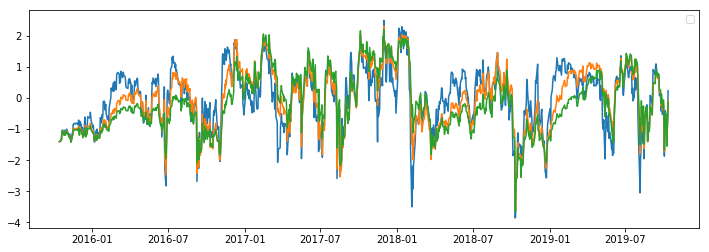

In [28]:
plt.figure(figsize=figsize)
plt.plot(signals)
plt.legend()

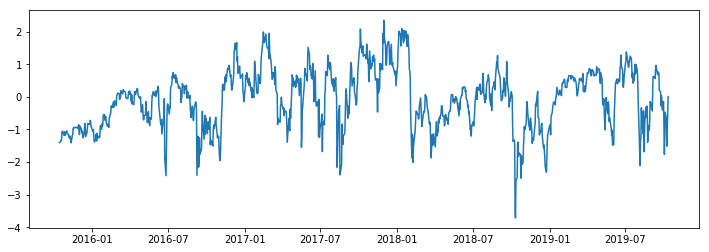

In [29]:
plt.figure(figsize=figsize)
plt.plot(macd_signal)

In [30]:
macd_pos = moskowitz_pos_func(macd_signal)
macd_pos.head()

Date
2015-10-12         NaN
2015-10-13         NaN
2015-10-14         NaN
2015-10-15         NaN
2015-10-16   -0.963714
dtype: float64

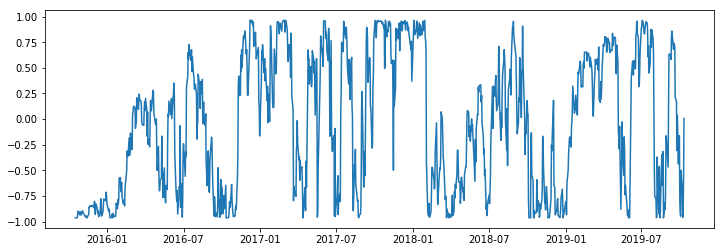

In [31]:
plt.figure(figsize=figsize)
plt.plot(macd_pos)

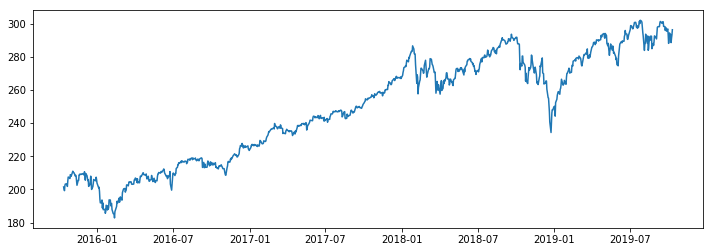

In [32]:
plt.figure(figsize=figsize)
plt.plot(close)

In [33]:
target_rets = rets.shift(1)
expected_return = target_rets * macd_pos
expected_return.head()

Date
2015-10-12          NaN
2015-10-13          NaN
2015-10-14          NaN
2015-10-15          NaN
2015-10-16   -13.694523
dtype: float64

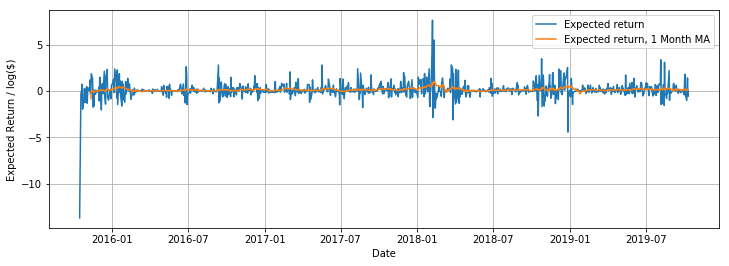

In [34]:
plt.figure(figsize=figsize)
plt.plot(expected_return, label="Expected return")
plt.plot(expected_return.rolling(20).mean(), label="Expected return, 1 Month MA")
plt.xlabel("Date")
plt.ylabel("Expected Return / log($)")
plt.legend()
plt.grid(True)

Text(0, 0.5, 'Cum Expected Return / log($)')

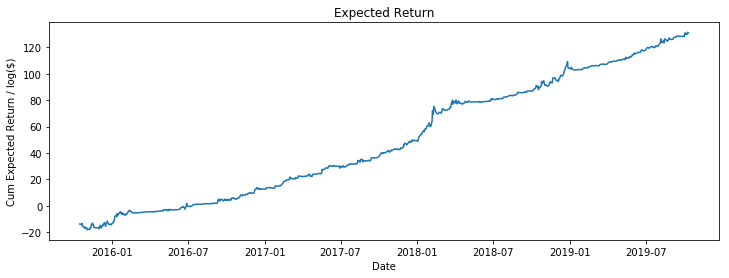

In [35]:
plt.figure(figsize=figsize)
plt.title('Expected Return')
plt.plot(np.cumsum(expected_return))
plt.xlabel("Date")
plt.ylabel("Cum Expected Return / log($)")

## Annualised Rolling Sharpe

In [0]:
rfr = 0.02 #risk free rate

In [37]:
annualised_sharpe = np.sqrt(252) * (expected_return.rolling(252).mean() - rfr) / expected_return.rolling(252).std()
annualised_sharpe.head()

Date
2015-10-12   NaN
2015-10-13   NaN
2015-10-14   NaN
2015-10-15   NaN
2015-10-16   NaN
dtype: float64

Text(0, 0.5, 'Annualised Sharpe')

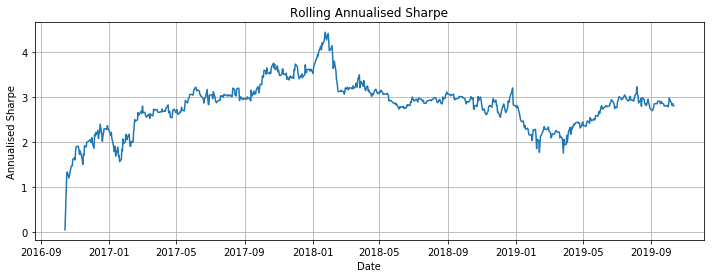

In [38]:
plt.figure(figsize=figsize)
plt.title("Rolling Annualised Sharpe")
plt.plot(annualised_sharpe)
plt.grid(True)
plt.xlabel("Date")
plt.ylabel("Annualised Sharpe")

## Transaction Cost Analysis

In [39]:
turnover = np.abs(macd_pos.diff())
turnover.head()

Date
2015-10-12   NaN
2015-10-13   NaN
2015-10-14   NaN
2015-10-15   NaN
2015-10-16   NaN
dtype: float64

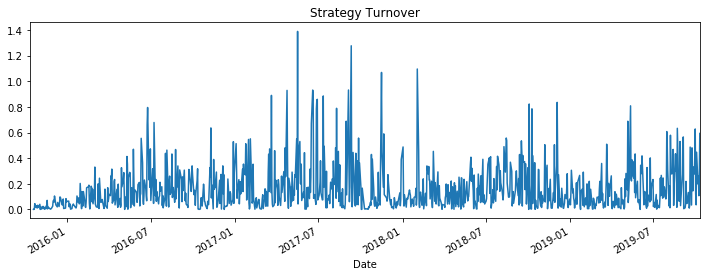

In [40]:
plt.figure(figsize=figsize)
plt.title("Strategy Turnover")
turnover.plot()

In [0]:
def get_perf(expected_rets, turnover, c):
  perf = expected_return - turnover * c
  return perf

In [0]:
costs = [1, 0.5, 1e-1, 1e-2, 1e-3]

Text(0, 0.5, 'Expected return / log($)')

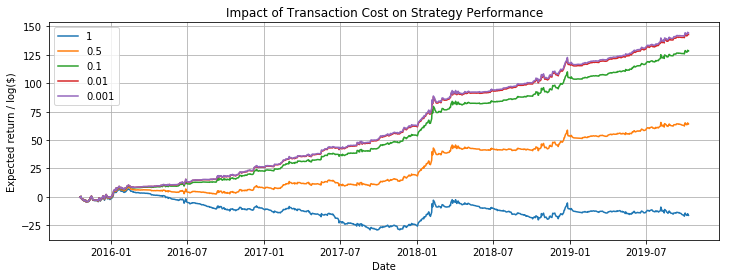

In [43]:
plt.figure(figsize=figsize)
for c in costs:
  perf = get_perf(expected_return, turnover, c)
  plt.plot(perf.cumsum(), label=c)

plt.title("Impact of Transaction Cost on Strategy Performance")
plt.legend()
plt.grid(True)
plt.xlabel("Date")
plt.ylabel("Expected return / log($)")

Text(0, 0.5, 'Sharpe')

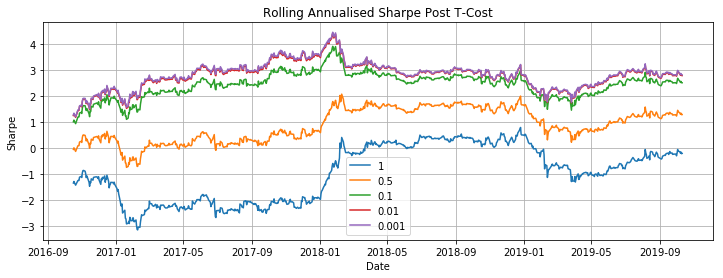

In [44]:
plt.figure(figsize=figsize)
for c in costs:
  perf = get_perf(expected_return, turnover, c)
  annualised_sharpe = np.sqrt(252) * (perf.rolling(252).mean() - rfr) / perf.rolling(252).std()
  plt.plot(annualised_sharpe, label=c)

plt.title("Rolling Annualised Sharpe Post T-Cost")
plt.legend()
plt.grid(True)
plt.xlabel("Date")
plt.ylabel("Sharpe")

## Diversification across securities:

*Left to the reader:* **Extend the strategy above to include the 6 tickers below (or any others you want to include).**

- How does this impact performance?
- Why do we do this?

In [0]:
tickers = ['EOD/BLK', 'EOD/ZNH', 'EOD/VTV', 'EOD/TCPC', 'EOD/SMPL', 'EOD/SMLF']

In [0]:
## your code goes here ##

# So why use Machine Learning?

The aim of machine learning is to partially automate the research process using historical data to find the future's optimal signal and positition.

### How can we do this?
- Create a strategy to learn the next step ahead and directly learn the position function.

### A naive approach:
- Model inputs: recent historical data
- Predict the next step ahead, the next timestep is the target value for the current timestep.
- Use mean squared error to calcuate the error from the prediction to the target value.
- Directly learn the position function so use tanh as the activation for the output layer.